# Cluster selection strategies

This notebook explains the ``hdbscan`` and ``plscan`` cluster selection
strategies and shows the effects of the ``min_samples`` and ``min_cluster_size``
parameters.

In [12]:
import warnings
import numpy as np
import pandas as pd
from plscan import PLSCAN
from hdbscan import HDBSCAN
from lib.plotting import *

configure_matplotlib()  # uses latex for text rendering!
data = np.load("data/clusterable/sources/clusterable_data.npy")

The function below runs the algorithms and plots their output in a nice
overview.

In [13]:
def plot_parameter_sweep(title, alg, leaf_width="distance", **kwargs):
    """Plots the clusters and cluster hierarchies detected by the given
    algorithm at several min_samples / min_cluster_size values."""
    sized_fig(1, 0.8 / 5 * 2)
    for i, size in enumerate([2, 5, 10, 50, 100]):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", FutureWarning)
            c = alg(min_samples=size, min_cluster_size=size, **kwargs).fit(data)
        plt.subplot(2, 5, i + 1)
        plot_kwargs = dict(s=1, cmap="tab10", vmax=9, vmin=0, edgecolors="none")
        plt.scatter(*data.T, c=c.labels_ % 10, **plot_kwargs)
        plt.title(f"$k={size}$", y=0.9)
        plt.xticks([])
        plt.yticks([])

        plt.subplot(2, 5, i + 6)
        if alg == HDBSCAN:
            palette = plt.cm.tab10.colors
            c.condensed_tree_.plot(
                select_clusters=True,
                colorbar=False,
                leaf_separation=0.5,
                selection_palette=palette,
            )

        else:
            c.leaf_tree_.plot(
                select_clusters=True,
                colorbar=False,
                leaf_separation=0.5,
                width=leaf_width,
            )
        plt.ylabel("")
        plt.yticks([])
    plt.subplot(2, 5, 6)
    if alg == PLSCAN:
        plt.ylabel("Min.~size", labelpad=0)
    else:
        plt.ylabel(r"$\lambda$ value", labelpad=0)
    plt.suptitle(title, y=1, fontsize=fontsize["normal"])
    plt.subplots_adjust(left=0.03, top=0.85, right=1, bottom=0, hspace=0, wspace=0.05)

## HDBSCAN* cluster selection

``hdbscan`` simplifies single linkage dendrograms using a minimum cluster size
to create a cluster hierarchy (`condensed_tree`). The cluster hierarchy forms a
*merge-tree* listing which connected components exist over all density values.
As density decreases, larger distance edges enter the filtration and create
connections between connected components, merging them in the hierarchy. The
process describes the data's 0-dimensional topology in a filtration over the
density, effectively implementing a *persistent homology* computation.

Clusters are selected from the hierarchy using one of two selection strategies.
The *leaf* strategy always selects the cluster tree's leaves. These clusters
correspond to all local density maxima meeting the size threshold. Effectively,
**this strategy defines clusters as local density maxima**. In practice,
leaf-clusters depend strongly on the minimum cluster size value used to
construct the cluster hierarchy. Many small leaf clusters can be detected for
small minimum cluster sizes, resulting in segmentations where most points are
classified as noise. 

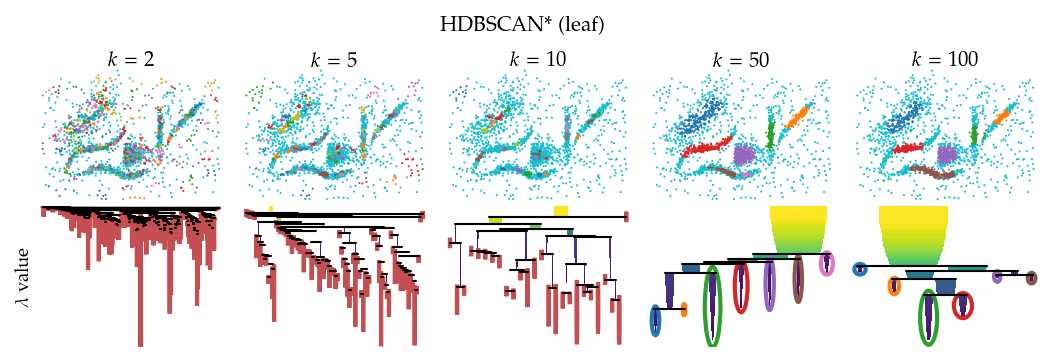

In [14]:
plot_parameter_sweep("HDBSCAN* (leaf)", HDBSCAN, cluster_selection_method="leaf")
plt.show()

The *EOM* strategy is more statistically motivated. It encourages fewer, larger
clusters by **defining clusters as a neighborhoods with an excess of probability
mass** (explained by Müller & Sawitzki, 1991). In statistical terms, the *EOM*
strategy interprets the density profile as a probability distribution and
computes its *modality*. Specifically, the strategy selects connected components
from the hierarchy that maximize a (relative) stability measure. The stability
measure aggregates the density-ranges in which points are part of a particular
connected component. It combines the number of points contained in the component
with the points' *persistence* in the density filtration. Selecting the most
persistent structures from a filtration as the *true* signal is common in
*persistent homology* and clustering (see, *cluster lifetime* referenced by
Campello et al., 2015). The stability adapts this notion to a cluster with
changing membership over density (Campello et al., 2015). While *EOM* clusters
are less sensitive to the minimum cluster size, they vary enough that the
parameter needs to be tuned to avoid small low-density clusters. Notice that
some clusters disappear at larger size thresholds.

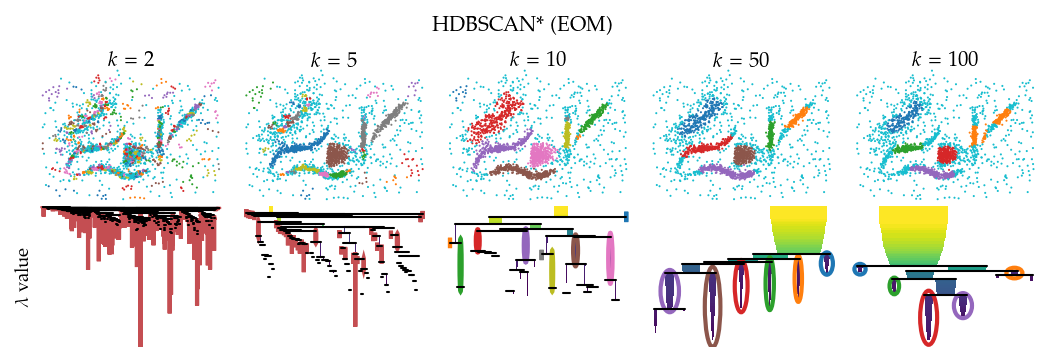

In [15]:
plot_parameter_sweep("HDBSCAN* (EOM)", HDBSCAN, cluster_selection_method="eom")
plt.show()

Both selection strategies can select clusters with varying densities that do not
correspond to a straight density-cut in the cluster hierarchy. In other words,
there may not be a single distance or density value for which DBSCAN produces
the same clusters.

## Persistent leaf-clusters

``plscan`` selects clusters by finding a minimum cluster size for which
leaf-clusters are optimal. Like *EOM*, the resulting clusters relate to the
density distributions modality, rather than all local maxima. 

The strategy performs a very efficient filtration over the minimum cluster size
parameter to create a leaf-cluster tree over all possible minimum cluster sizes.
It then finds the `min_cluster_size` parameter that maximizes a quality measure.
The result is **a (practically) parameter free clustering algorithm that
produces *EOM*-like clusters** and a cluster hierarchy describing leaf-clusters
at other size thresholds. 

The ``min_samples`` parameter in ``plscan`` smooths the computed density profile
which prunes small, low-persistent leaves from the the leaf-cluster tree. Unlike
``hdbscan``'s minimum cluster size parameter, **changing ``min_samples`` in
``plscan`` does not really change which clusters are selected**. At higher
`min_samples` the selected clusters becomes smaller, with more points classified
as noise. This suggests low `min_samples` values work better. However, at too
low values (i.e., `min_samples=2` below), the resulting clusters might to
sensitive to local density changes.

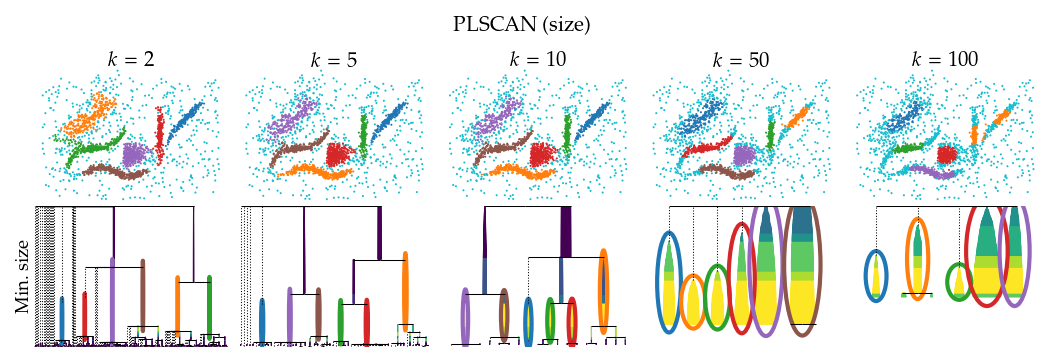

In [16]:
plot_parameter_sweep("PLSCAN (size)", PLSCAN)
plt.show()

The other size-based [persistence measures](./using_bi_persistences.ipynb) in
``plscan`` behave similarly:

- distance persistence

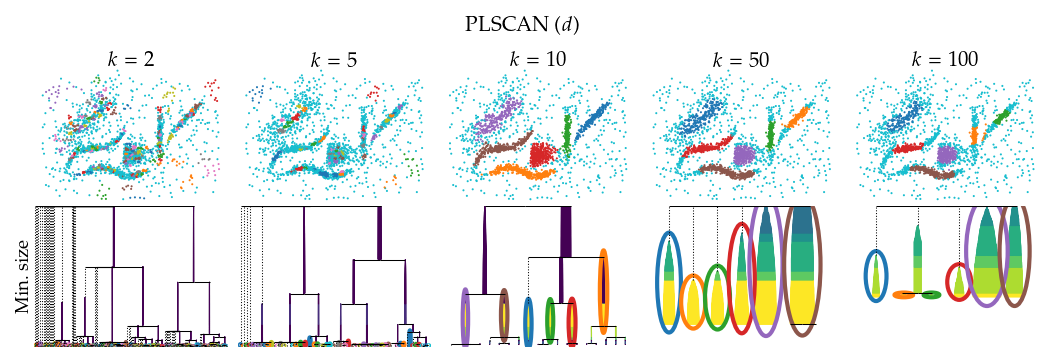

In [17]:
plot_parameter_sweep("PLSCAN ($d$)", PLSCAN, persistence_measure="distance")
plt.show()

- density persistence

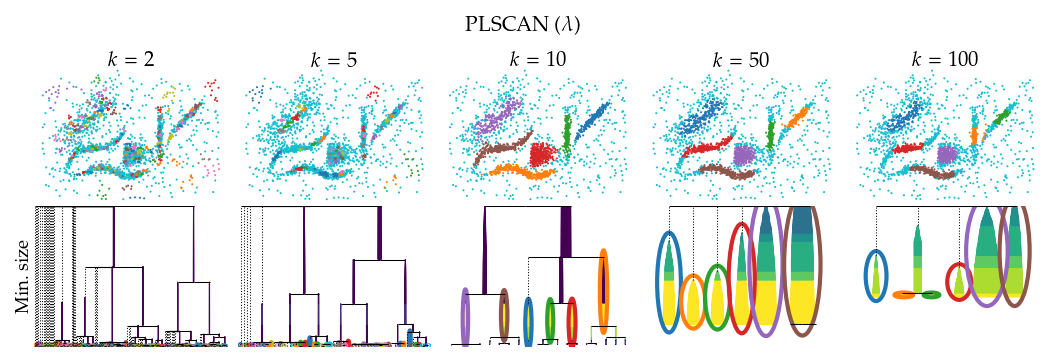

In [18]:
plot_parameter_sweep("PLSCAN ($\\lambda$)", PLSCAN, persistence_measure="density")
plt.show()

- size--distance bi-persistence

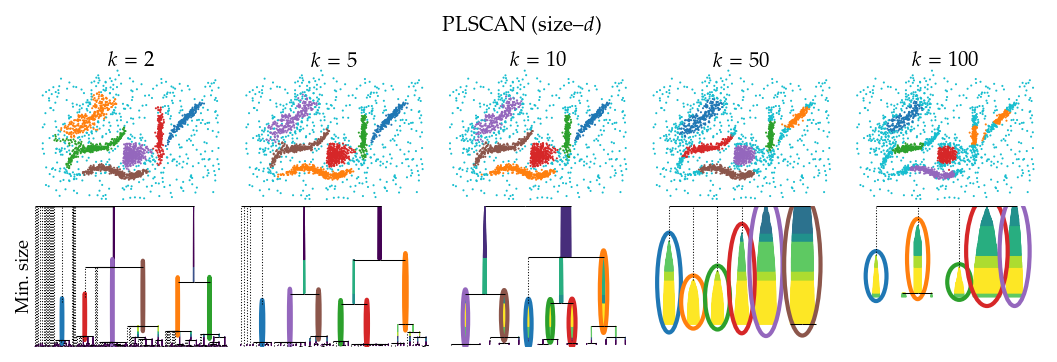

In [19]:
plot_parameter_sweep("PLSCAN (size--$d$)", PLSCAN, persistence_measure="size-distance")
plt.show()

- size--density bi-persistence

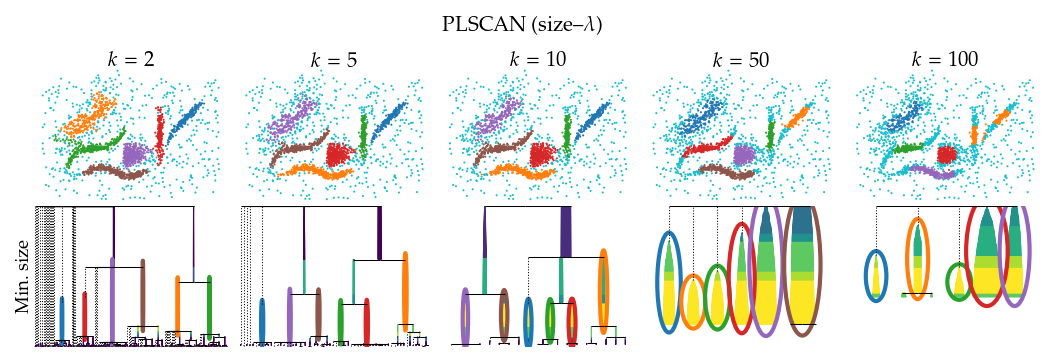

In [20]:
plot_parameter_sweep(
    "PLSCAN (size--$\\lambda$)",
    PLSCAN,
    persistence_measure="size-density",
    leaf_width="density",
)
plt.show()